In [2]:
# %%  [OFFLINE INSTALL  — robust + same UX]  🚀
"""
Identical behaviour to the original:

  • shows /kaggle/working and /kaggle/input
  • locates *offline_pkgs_clean.zip* + *requirements_freeze.txt*
  • un-zips → pip install --no-index → verifies

…with **extras**:

  • deletes /kaggle/working/{offline_pkgs, offline_pkgs_dataset, pkg_upload}
    at the very top to reclaim disk space
  • still searches everywhere under both trees, warns on duplicates
  • prints a friendly hint and simply **skips** the install step when artefacts
    are missing (no crash, notebook keeps going)
  • optional stub to rebuild the wheel-house if you really have to
"""
import pathlib, zipfile, subprocess, platform, sys, textwrap, shutil, os, datetime

# ── CONFIG ──────────────────────────────────────────────────────────────
INPUT_ROOT = pathlib.Path("/kaggle/input")      # read-only datasets
WORK_ROOT  = pathlib.Path("/kaggle/working")    # writable directory
ZIP_NAME   = "offline_pkgs_clean.zip"
REQ_NAME   = "requirements_freeze.txt"
CLEAN_DIRS = ["offline_pkgs", "offline_pkgs_dataset", "pkg_upload"]  # ← free space
WORK       = WORK_ROOT.resolve()
# ────────────────────────────────────────────────────────────────────────

# 🗑️ PRE-STEP: Remove big, no-longer-needed directories ------------------
for name in CLEAN_DIRS:
    d = WORK_ROOT / name
    if d.exists():
        print(f"[INFO] Deleting {d} to save space…")
        shutil.rmtree(d, ignore_errors=True)

print(f"\nPython {sys.version.split()[0]} on {platform.platform()}")
print(f"[{datetime.datetime.utcnow().isoformat(timespec='seconds')} UTC]\n")

# 🔎 0️⃣  Show what’s in /kaggle/working ----------------------------------
print("[INFO] Contents of /kaggle/working:")
for p in WORK_ROOT.rglob("*"):
    print("  ", p.relative_to(WORK_ROOT))

print("\n[INFO] Contents of /kaggle/input:")
for p in INPUT_ROOT.rglob("*"):
    print("  ", p.relative_to(INPUT_ROOT))

# 1️⃣  Locate the ZIP and requirements files -----------------------------
def find_unique(name: str):
    """Return *one* Path for `name`, searching both input + working trees."""
    hits = list(INPUT_ROOT.rglob(name)) + list(WORK_ROOT.rglob(name))
    if not hits:
        return None
    if len(hits) > 1:
        print(f"[WARN] Multiple '{name}' found – using the first hit:\n  " +
              "\n  ".join(map(str, hits)))
    return hits[0]

zip_path = find_unique(ZIP_NAME)
req_path = find_unique(REQ_NAME)

if not zip_path or not req_path:
    print(textwrap.dedent(f"""
        ⚠️  Could not locate both artefacts:

              {ZIP_NAME if not zip_path else '✓'}    {zip_path or '(missing)'}
              {REQ_NAME if not req_path else '✓'}    {req_path or '(missing)'}

        • If you already created a wheel-house dataset, add it via “Add Data”.
        • Otherwise rebuild the archive in /kaggle/working (see optional stub below).

        Skipping the offline-install step for now.
    """))
    # -------------------------------------------------------------------
    # OPTIONAL – uncomment to rebuild the wheel-house in-place
    # from previous cells if you really need it:
    #
    #   from build_offline_wheelhouse import build  # hypothetical helper
    #   build(output_dir=WORK_ROOT)  # recreates ZIP + requirements file
    #   zip_path = WORK_ROOT / ZIP_NAME
    #   req_path = WORK_ROOT / REQ_NAME
    #
    # -------------------------------------------------------------------
else:  # ← only run the heavy stuff when we actually have the files
    print(f"\n[INFO] Using ZIP from: {zip_path}")
    print(f"[INFO] Using REQ from: {req_path}")

    DEST = WORK / "offline_pkgs"      # unzip target folder

    # 2️⃣  Unzip wheelhouse ----------------------------------------------
    if DEST.exists():
        shutil.rmtree(DEST)
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall(WORK)
    print(f"[INFO] Extracted wheels to {DEST}")

    # 3️⃣  Install offline ----------------------------------------------
    cmd = [
        "pip", "install",
        "--no-index",
        "--find-links", str(DEST),
        "-r", str(req_path),
    ]
    print("[INFO] Installing packages (no-index)…\n")

    proc = subprocess.run(cmd, capture_output=True, text=True)
    if proc.returncode != 0:
        print("⚠️  pip exited with a non-zero status. Full stderr follows:\n")
        print(proc.stderr)
    else:
        print(proc.stdout)

    # 4️⃣  Verify (even if some installs failed) -------------------------
    print("\n[INFO] Final package snapshot:")
    subprocess.run(["pip", "list", "--format=columns", "--disable-pip-version-check"])

    print(textwrap.dedent(f"""
        ✅  Offline installation step complete!
        You can inspect the log above for any packages that failed. Re-run pip
        manually or edit {REQ_NAME} to comment out problematic lines, then rerun
        this cell if needed.
    """))

# ℹ️ Optional: exhaustive /kaggle/input listing (commented out — can be verbose)
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20 GB to the current directory (/kaggle/working/) that
# gets preserved when you create a version using “Save & Run All”. Temporary
# files in /kaggle/temp/ are not persisted.


Python 3.10.12 on Linux-6.6.56+-x86_64-with-glibc2.35
[2025-05-12T19:18:37 UTC]

[INFO] Contents of /kaggle/working:
   .virtual_documents

[INFO] Contents of /kaggle/input:
   kaggle-api
   block-sparse-wheels
   hydra-core-132whl
   rna-structure-predict
   stanford-rna-3d-folding
   rna-torsion-bert-checkpoint-base
   kaggle-api/kaggle.json
   block-sparse-wheels/block_sparse_attn-0.0.1cu118torch2.0cxx11abiTRUE-cp310-cp310-linux_x86_64.whl
   hydra-core-132whl/hydra_core-1.3.2-py3-none-any.whl
   rna-structure-predict/rna_predict-1.0.0-py3-none-any.whl
   rna-structure-predict/rna_predict-0.1.0-py3-none-any.whl
   rna-structure-predict/rna_predict-0.1.3-py3-none-any.whl
   rna-structure-predict/rna_predict-0.1.1-py3-none-any.whl
   rna-structure-predict/rna_predict-0.1.2-py3-none-any.whl
   stanford-rna-3d-folding/MSA
   stanford-rna-3d-folding/sample_submission.csv
   stanford-rna-3d-folding/validation_sequences.csv
   stanford-rna-3d-folding/MSA_v2
   stanford-rna-3d-folding/test

In [3]:
# ---
# Cell: ALL-IN-ONE Environment Setup  (no uninstalls, no online pip)
# ---

import sys, subprocess, shutil, os, platform

def run_and_print(cmd):
    res = subprocess.run(cmd, capture_output=True, text=True)
    print(res.stdout, end="")
    if res.stderr:
        print(res.stderr, end="")

# ══════ 1)  System information (unchanged) ════════════════════════════════
print("\n=== [System Information] ===")

print("\n[Python Version]")
print(sys.version)

print("\n[Kernel and OS Information]")
run_and_print(["uname", "-a"])

print("\n[CPU Information]")
run_and_print(["lscpu"])

print("\n[Memory Information]")
run_and_print(["free", "-mh"])

print("\n[Disk Information]")
run_and_print(["lsblk"])

print("\n=== [End of System Information] ===\n")

# ══════ 2)  USER CONFIG  ══════════════════════════════════════════════════
RNA_PREDICT_VERSION   = "1.0.0"
BLOCK_SPARSE_WHEEL_IN = (
    "/kaggle/input/block-sparse-wheels/"
    "block_sparse_attn-0.0.1cu118torch2.0cxx11abiTRUE-"
    "cp310-cp310-linux_x86_64.whl"
)
# PEP 440-compliant rename (Torch version tag trimmed)
BLOCK_SPARSE_WHEEL_OUT = (
    "/kaggle/working/"
    "block_sparse_attn-0.0.1+cu118torch2.0-"
    "cp310-cp310-linux_x86_64.whl"
)

# ══════ 3)  Environment-fix helper  ═══════════════════════════════════════
def setup_environment():
    """
    ① Ensure Seaborn (and its deps) is present
    ② Copy & install block_sparse_attn wheel   ← optional; see note below
    ③ Install rna_predict
    ④ Install hydra-core from local wheel
    ⑤ Show final versions of key packages
    """
    # ① Make sure Seaborn is available –
    #    Kaggle base image already has 0.12.2 but we pin it explicitly:
    print("[INFO] Making sure Seaborn is installed…\n")
    run_and_print(["pip", "install", "--quiet", "seaborn==0.12.2"])

    # ② Copy & (optionally) install block_sparse_attn
    if os.path.exists(BLOCK_SPARSE_WHEEL_IN):
        try:
            shutil.copyfile(BLOCK_SPARSE_WHEEL_IN, BLOCK_SPARSE_WHEEL_OUT)
            print("\n[INFO] Copied block-sparse-attn wheel to working dir.")
            print("[INFO] Installing block-sparse-attn (no deps)…\n")
            run_and_print(["pip", "install", "--no-deps", "--quiet", BLOCK_SPARSE_WHEEL_OUT])
        except Exception as e:
            print(f"[WARN] Could not copy/install block-sparse wheel: {e}")
            print("       Continue without it if your code doesn’t need it.")
    else:
        print("[WARN] block-sparse-attn wheel not found in /kaggle/input – skipped.")

    # ③ Install rna_predict (pure-py, so --no-deps is fine)
    rnapred_whl = f"/kaggle/input/rna-structure-predict/" \
                  f"rna_predict-{RNA_PREDICT_VERSION}-py3-none-any.whl"
    if os.path.exists(rnapred_whl):
        print(f"\n[INFO] Installing rna_predict {RNA_PREDICT_VERSION} …\n")
        run_and_print(["pip", "install", "--no-deps", "--quiet", rnapred_whl])
    else:
        print(f"[WARN] {rnapred_whl} not found – skipped.")

    # ④ Install hydra-core from local wheel
    HYDRA_DIR = "/kaggle/input/hydra-core-132whl"
    if os.path.isdir(HYDRA_DIR):
        wheels = [f for f in os.listdir(HYDRA_DIR) if f.endswith(".whl")]
        if wheels:
            for whl in wheels:
                whl_path = os.path.join(HYDRA_DIR, whl)
                print(f"\n[INFO] Installing hydra-core from {whl_path} …\n")
                run_and_print(["pip", "install", "--no-deps", "--quiet", whl_path])
        else:
            print(f"[WARN] No .whl files found in {HYDRA_DIR} – skipped.")
    else:
        print(f"[WARN] {HYDRA_DIR} not found – skipped.")

    # ⑤ Show final versions
    print("\n=== [Final Package Versions] ===")
    for pkg in [
        "torch", "block-sparse-attn", "rna-predict",
        "hydra-core", "numpy", "scipy", "scikit-learn", "seaborn"
    ]:
        run_and_print(["pip", "show", pkg])
    print("=== [End of Final Package Versions] ===\n")

# ══════ 4)  Run it  ═══════════════════════════════════════════════════════
setup_environment()


=== [System Information] ===

[Python Version]
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]

[Kernel and OS Information]
Linux b0c7180d5a08 6.6.56+ #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux

[CPU Information]
Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               4
On-line CPU(s) list:                  0-3
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
CPU family:                           6
Model:                                79
Thread(s) per core:                   2
Core(s) per socket:                   2
Socket(s):                            1
Stepping:                             0
BogoMIPS:                             4400.40
Flags:                          

In [4]:
# -*- coding: utf-8 -*-
"""
Cell 1: ENVIRONMENT SETUP & LOGGING
-----------------------------------
"""
import os
import sys
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


# Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logging.info("Cell 1 complete: Libraries imported and logging initialized.")


In [5]:
"""
Cell 2: DATA IMPORT
-------------------
Here, we read in train/validation/test CSVs and a sample submission from the Kaggle environment.
Adjust the paths if needed for your environment.
"""

# Example file paths
TRAIN_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv"
TRAIN_LABELS_PATH    = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv"
VALID_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv"
VALID_LABELS_PATH    = "/kaggle/input/stanford-rna-3d-folding/validation_labels.csv"
TEST_SEQUENCES_PATH  = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv"
SAMPLE_SUB_PATH      = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv"

try:
    train_sequences = pd.read_csv(TRAIN_SEQUENCES_PATH)
    train_labels = pd.read_csv(TRAIN_LABELS_PATH)
    validation_sequences = pd.read_csv(VALID_SEQUENCES_PATH)
    validation_labels = pd.read_csv(VALID_LABELS_PATH)
    test_sequences = pd.read_csv(TEST_SEQUENCES_PATH)
    sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

    logging.info("Cell 2 complete: Data loaded successfully.")
except Exception as e:
    logging.error(f"Error loading data: {e}")
    sys.exit(1)

logging.info(f"train_sequences: {train_sequences.shape}, train_labels: {train_labels.shape}")
logging.info(f"validation_sequences: {validation_sequences.shape}, validation_labels: {validation_labels.shape}")
logging.info(f"test_sequences: {test_sequences.shape}, sample_submission: {sample_submission.shape}")

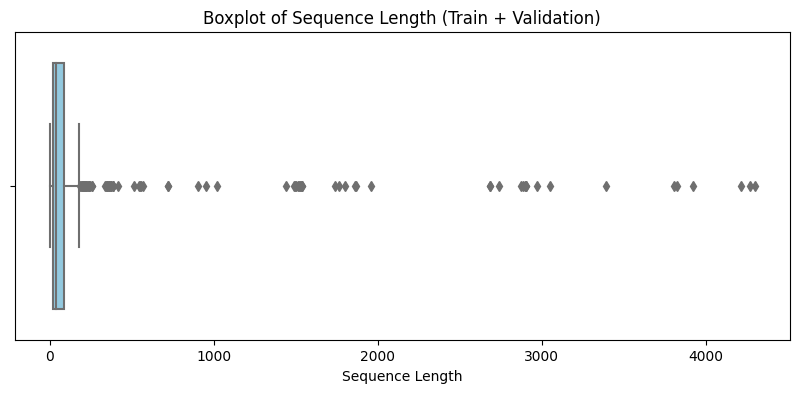

In [6]:
"""
Cell 3: COMBINE TRAIN + VALIDATION & BASIC EDA
----------------------------------------------
We concatenate the train and validation sets to maximize data. 
Then we do a quick EDA check on shapes, missingness, etc.
"""

# Combine sequences and labels
trainval_sequences = pd.concat([train_sequences, validation_sequences], ignore_index=True)
trainval_labels = pd.concat([train_labels, validation_labels], ignore_index=True)

logging.info(f"Combined train+validation sequences: {trainval_sequences.shape}, labels: {trainval_labels.shape}")

# Quick check for missing
logging.info("Missing in combined sequences:\n" + str(trainval_sequences.isnull().sum()))
logging.info("Missing in combined labels:\n" + str(trainval_labels.isnull().sum()))

# Example EDA: sequence length distribution
trainval_sequences['sequence_length'] = trainval_sequences['sequence'].str.len()

plt.figure(figsize=(10,4))
sns.boxplot(x=trainval_sequences['sequence_length'], color='skyblue')
plt.title("Boxplot of Sequence Length (Train + Validation)")
plt.xlabel("Sequence Length")
plt.show()

logging.info("Cell 3 complete: Basic EDA finished.")

In [7]:
"""
Cell 4: HANDLE MISSING COORDINATES & MERGE
------------------------------------------
We replace '-1e18' with np.nan, then merge sequences with labels on target_id.
"""

# Replace -1e18 with np.nan in the labels
for col in ['x_1','y_1','z_1']:
    trainval_labels[col] = trainval_labels[col].replace(-1e18, np.nan)

logging.info("Replaced -1e18 with NaN in trainval_labels for x_1, y_1, z_1.")

# Extract pdb_id, chain_id from ID
trainval_labels['pdb_id']   = trainval_labels['ID'].apply(lambda x: x.split('_')[0])
trainval_labels['chain_id'] = trainval_labels['ID'].apply(lambda x: x.split('_')[1])
trainval_labels['target_id'] = trainval_labels['pdb_id'] + "_" + trainval_labels['chain_id']

# Merge
train_data = pd.merge(trainval_labels, trainval_sequences, on='target_id', how='left')
logging.info(f"Merged train_data shape: {train_data.shape}")

# Quick check
logging.info(f"Missing in x_1: {train_data['x_1'].isnull().sum()}, "
             f"y_1: {train_data['y_1'].isnull().sum()}, "
             f"z_1: {train_data['z_1'].isnull().sum()}")

logging.info("Cell 4 complete: Merged train_data, ready for group-based imputation.")

In [8]:
"""
Cell 5: FEATURE ENGINEERING
---------------------------
Create numerical/categorical features from the 'sequence'.
We'll keep 'resname' from the labels as a valuable feature.
"""

def engineer_features(df):
    """
    Create numerical & (some) categorical features from raw RNA sequence data.
    """
    df = df.copy()
    # Sequence-based
    df['seq_length'] = df['sequence'].str.len()
    df['A_cnt'] = df['sequence'].str.count('A')
    df['C_cnt'] = df['sequence'].str.count('C')
    df['G_cnt'] = df['sequence'].str.count('G')
    df['U_cnt'] = df['sequence'].str.count('U')
    df['begin_seq'] = df['sequence'].str[0]
    df['end_seq']   = df['sequence'].str[-1]
    
    # Di-nucleotide counts (example set)
    for pair in ['AC','AG','AU','CA','CG','CU','GA','GC','GU','UA','UC','UG',
                 'AA','CC','GG','UU']:
        df[f'{pair}_cnt'] = df['sequence'].str.count(pair)

    return df

# Apply feature engineering
train_data = engineer_features(train_data)

logging.info("Feature engineering applied to merged train_data.")

# We'll show an example of newly added columns
example_cols = ['seq_length','A_cnt','C_cnt','G_cnt','U_cnt','begin_seq','end_seq','AC_cnt','AA_cnt']
logging.info(f"Columns after FE sample:\n{train_data[example_cols].head(3)}")

logging.info("Cell 5 complete: Feature engineering done.")

In [9]:
"""
Cell 6: GROUP-BASED IMPUTATION
------------------------------
We impute missing x_1, y_1, z_1 within each (target_id, resname) group.
Finally, if any NAs remain, we fill them with a global median or drop them.
"""

# Perform group-based fill for x_1, y_1, z_1
train_data[['x_1','y_1','z_1']] = (
    train_data
    .groupby(['target_id','resname'])[['x_1','y_1','z_1']]
    .apply(lambda grp: grp.fillna(grp.mean()))
    .reset_index(level=['target_id','resname'], drop=True)
)

# In case any remain after group-based mean fill (e.g. group is all NaN), do a global fill
num_cols = ['x_1','y_1','z_1']
global_imputer = SimpleImputer(strategy='median')
train_data[num_cols] = global_imputer.fit_transform(train_data[num_cols])

# If you'd prefer to drop any leftover NAs instead:
# train_data.dropna(subset=['x_1','y_1','z_1'], inplace=True)

logging.info("Group-based imputation + global median fallback complete.")

# Confirm missing values
logging.info(f"Remaining missing x_1: {train_data['x_1'].isna().sum()}, "
             f"y_1: {train_data['y_1'].isna().sum()}, z_1: {train_data['z_1'].isna().sum()}")

logging.info("Cell 6 complete: Group-based imputation finished.")

In [10]:
"""
Cell 7: PREPARE DATA FOR MODELING
---------------------------------
We'll define the columns we won't use, set up X and y for x_1, y_1, z_1, 
and one-hot encode any relevant categorical columns (including resname).
"""

# Unused columns
unused_cols = [
    'ID','pdb_id','chain_id','resid',
    'x_1','y_1','z_1',
    'sequence','description','temporal_cutoff','all_sequences',
    'target_id'  # key used for merges
]

# We'll keep resname, begin_seq, end_seq as features this time
feature_cols = [col for col in train_data.columns if col not in unused_cols]

# Make a copy
train_df = train_data.copy()

# Convert to categories
for cat_col in ['resname','begin_seq','end_seq']:
    if cat_col in feature_cols:
        train_df[cat_col] = train_df[cat_col].astype('category')

# One-hot encode
train_df = pd.get_dummies(train_df, columns=['resname','begin_seq','end_seq'], drop_first=True)

# Our final set of features
X_cols = [col for col in train_df.columns if col not in unused_cols]

X_full = train_df[X_cols]
y_x_full = train_df['x_1']
y_y_full = train_df['y_1']
y_z_full = train_df['z_1']

logging.info(f"Feature matrix shape: {X_full.shape}")
logging.info("Cell 7 complete: Prepared data for modeling.")

In [11]:
"""
Cell 8: KFold CV for X, Y, Z & Hyperparam Search
------------------------------------------------
We'll do a simplified KFold cross-validation for each coordinate 
to get a sense of good hyperparams, then train final models.
"""

from sklearn.model_selection import KFold, RandomizedSearchCV
import numpy as np

# Example hyperparameter grid (you can expand as needed)
param_dist = {
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [6, 10, 15],
    'n_estimators': [500, 800, 1000],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

def run_random_search(X, y, param_dist, n_iter=5, cv_splits=3):
    """Simple RandomizedSearchCV for an XGBRegressor using GPU in XGBoost >= 2.0."""
    xgb = XGBRegressor(tree_method='hist', device='cuda', random_state=42)
    rsearch = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=cv_splits,
        verbose=1,
        random_state=42
    )
    rsearch.fit(X, y)
    best_model = rsearch.best_estimator_
    logging.info(f"Best params: {rsearch.best_params_}, Best CV Score: {rsearch.best_score_}")
    return best_model, rsearch.best_params_

logging.info("Starting hyperparam search for X coordinate.")
#best_model_x, best_params_x = run_random_search(X_full, y_x_full, param_dist, n_iter=5, cv_splits=3)

logging.info("Starting hyperparam search for Y coordinate.")
#best_model_y, best_params_y = run_random_search(X_full, y_y_full, param_dist, n_iter=5, cv_splits=3)

logging.info("Starting hyperparam search for Z coordinate.")
#best_model_z, best_params_z = run_random_search(X_full, y_z_full, param_dist, n_iter=5, cv_splits=3)

logging.info("Cell 8 complete: RandomizedSearchCV best params found.")

In [12]:
"""
Cell 9: FINAL TRAINING ON FULL DATA
-----------------------------------
Use the best hyperparams for each coordinate found in CV. 
Retrain each coordinate model on all data (X_full, y_*_full).
"""

def get_best_xgb(params):
    """ Return an XGBRegressor with the given params, using GPU. """
    # Here we override or add 'tree_method' to ensure GPU usage
    # We can also specify predictor='gpu_predictor' to accelerate inference on GPU
    model = XGBRegressor(
        **params,
        tree_method='hist',   # or tree_method=params.get('tree_method', 'hist')
        device='cuda',        # ensures GPU usage
        random_state=42
    )
    return model

logging.info("Retraining final model for X coordinate...")
#model_x = get_best_xgb(best_params_x)
#model_x.fit(X_full, y_x_full)

logging.info("Retraining final model for Y coordinate...")
#model_y = get_best_xgb(best_params_y)
#model_y.fit(X_full, y_y_full)

logging.info("Retraining final model for Z coordinate...")
#model_z = get_best_xgb(best_params_z)
#model_z.fit(X_full, y_z_full)

logging.info("Cell 9 complete: Final models trained.")

In [13]:
"""
Cell 10: PREPARE & ENGINEER TEST DATA
-------------------------------------
• Expand test_sequences into (ID, resname, resid)
• Merge residue‑level grid with per‑sequence engineered features
• Align with training feature matrix X_full, fill missing values
"""

# ---------- 1. Expand residue grid ----------
test_expanded = [
    [row["target_id"], nt, i]
    for _, row in test_sequences.iterrows()
    for i, nt in enumerate(row["sequence"], start=1)
]
test_clean_df = pd.DataFrame(test_expanded, columns=["ID", "resname", "resid"])
logging.info(f"test_clean_df shape: {test_clean_df.shape} (expanded test sequences)")

# ---------- 2. Per‑sequence engineered features ----------
test_feats = engineer_features(test_sequences)

# Merge – one row per residue, sequence‑level features broadcast to each residue
test_merged = pd.merge(
    test_clean_df,
    test_feats.drop(columns=["seq_length"]),   # drop if not needed
    left_on="ID",
    right_on="target_id",
    how="left"
)
logging.info(f"test_merged shape after merging: {test_merged.shape}")

# ---------- 3. Clean up ----------
# Replace sentinel values
for col in ["x_1", "y_1", "z_1"]:
    if col in test_merged.columns:
        test_merged[col] = test_merged[col].replace(-1e18, np.nan)

# Drop columns not used by the model
drop_cols = ["sequence", "description", "temporal_cutoff", "all_sequences", "target_id"]
test_merged.drop(columns=[c for c in drop_cols if c in test_merged.columns], inplace=True, errors="ignore")

# ---------- 4. Categorical handling ----------
cat_cols = {"resname", "begin_seq", "end_seq"} & set(test_merged.columns)
for col in cat_cols:
    test_merged[col] = test_merged[col].astype("category")
test_merged = pd.get_dummies(test_merged, columns=list(cat_cols), drop_first=True)

# ---------- 5. Column alignment ----------
# Single vectorised reindex instead of per‑column insertion → no fragmentation warning
test_merged = test_merged.reindex(columns=X_full.columns, fill_value=0)

# ---------- 6. Missing‑value imputation ----------
# Fit a NEW median imputer on the training feature matrix (numeric cols only)
numeric_cols = X_full.select_dtypes(include=np.number).columns
feature_imputer = SimpleImputer(strategy="median")
feature_imputer.fit(X_full[numeric_cols])

test_merged[numeric_cols] = feature_imputer.transform(test_merged[numeric_cols])

# ---------- 7. All done ----------
test_merged_imputed = test_merged.copy()
logging.info("Cell 10 complete: Test data prepared, aligned, and imputed.")

In [24]:
%%bash
# Cell: Download & Package DNA_Bert_3 checkpoint (internet required)
# ------------------------------------------------------------------
git lfs install
git clone https://huggingface.co/zhihan1996/DNA_bert_3 /kaggle/working/DNA_bert_3

# (Optional) clone just pointers, then pull large files:
# GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/zhihan1996/DNA_bert_3 /kaggle/working/DNA_bert_3
# cd /kaggle/working/DNA_bert_3 && git lfs pull

# Symlink into the path Transformers expects for offline loading:
mkdir -p /kaggle/working/zhihan1996
ln -sf /kaggle/working/DNA_bert_3 /kaggle/working/zhihan1996/DNA_bert_3

# Package into a zip for dataset upload:
zip -r /kaggle/working/DNA_bert_3.zip /kaggle/working/DNA_bert_3

Git LFS initialized.
	zip warning: name not matched: /kaggle/working/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3/DNA_bert_3
  adding: kaggle/working/DNA_bert_3/ (stored 0%)
  adding: kaggle/working/DNA_bert_3/.git/ (stored 0%)
  adding: kaggle/working/DNA_bert_3/.git/HEAD (stored 0%)
  adding: kaggle/working/DNA_bert_3/.git/refs/ (stored 0%)
  adding: kaggle/working/DNA_bert_3/.git/refs/heads/ (stored 0%)
  adding: kaggle/working/DNA_bert_3/.git/refs/heads/main (stored 0%)
  adding: kaggle/working/DNA_bert_3/.git/refs/remotes/ (stored 0%)
  adding: kaggle/working/DNA_bert_3/.git/refs/re

Cloning into '/kaggle/working/DNA_bert_3'...


CalledProcessError: Command 'b'# Cell: Download & Package DNA_Bert_3 checkpoint (internet required)\n# ------------------------------------------------------------------\ngit lfs install\ngit clone https://huggingface.co/zhihan1996/DNA_bert_3 /kaggle/working/DNA_bert_3\n\n# (Optional) clone just pointers, then pull large files:\n# GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/zhihan1996/DNA_bert_3 /kaggle/working/DNA_bert_3\n# cd /kaggle/working/DNA_bert_3 && git lfs pull\n\n# Symlink into the path Transformers expects for offline loading:\nmkdir -p /kaggle/working/zhihan1996\nln -sf /kaggle/working/DNA_bert_3 /kaggle/working/zhihan1996/DNA_bert_3\n\n# Package into a zip for dataset upload:\nzip -r /kaggle/working/DNA_bert_3.zip /kaggle/working/DNA_bert_3\n'' returned non-zero exit status 14.

In [15]:
!HF_DATASETS_OFFLINE=1 TRANSFORMERS_OFFLINE=1 HF_HOME=/kaggle/working TRANSFORMERS_CACHE=/kaggle/working ln -sf /kaggle/input/rna-torsion-bert-checkpoint-base/kaggle/working/rna_torsionBERT /kaggle/working/rna_torsionBERT

In [18]:
# Cell: RNA Prediction with TorsionBERT
# --------------------------------------------
import pandas as pd
import torch
from omegaconf import OmegaConf
import os
import logging
import time
import sys

# ─── Link the checkpoint and enable offline mode ──────────────────────────────
# (symlink extracted checkpoint into working dir so transformers sees it)
if not os.path.exists("/kaggle/working/rna_torsionBERT"):
    os.symlink(
        "/kaggle/input/rna-torsion-bert-checkpoint-base/kaggle/working/rna_torsionBERT",
        "/kaggle/working/rna_torsionBERT"
    )

# Point at HF hub offline flags and cache dirs
os.environ["HF_HUB_OFFLINE"]       = "1"
os.environ["HF_DATASETS_OFFLINE"]   = "1"
os.environ["TRANSFORMERS_OFFLINE"]   = "1"
os.environ["HF_HOME"]               = "/kaggle/working"
os.environ["TRANSFORMERS_CACHE"]     = "/kaggle/working"

# ─── Monkey-patch transformers to enforce local_files_only ────────────────────
from functools import partial
import transformers
transformers.AutoConfig.from_pretrained    = partial(transformers.AutoConfig.from_pretrained,    local_files_only=True)
transformers.AutoTokenizer.from_pretrained = partial(transformers.AutoTokenizer.from_pretrained, local_files_only=True)
transformers.AutoModel.from_pretrained     = partial(transformers.AutoModel.from_pretrained,     local_files_only=True)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Helper function for running shell commands
def run_and_print(cmd_list):
    import subprocess
    result = subprocess.run(cmd_list, capture_output=True, text=True)
    print(result.stdout, end="")
    if result.stderr:
        print("STDERR:", result.stderr, end="")
    return result

# Install dependencies
missing_pkgs = ["hydra-core==1.3.2", "omegaconf==2.3.0"]
print("[INFO] Installing missing runtime packages:", ", ".join(missing_pkgs))
run_and_print(["pip", "install", "--no-cache-dir", "--no-deps"] + missing_pkgs)

# Verify installation
run_and_print([
    "python", "-c",
    "import hydra, omegoconf, sys; "
    "print('hydra', hydra.__version__, '| omegoconf', omegaconf.__version__)"
])

# Import the RNAPredictor after installing dependencies
from rna_predict.interface import RNAPredictor

# Example file paths - adjust as needed for your environment
TEST_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv"
SAMPLE_SUB_PATH     = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv"
OUTPUT_PATH         = "submission.csv"  # Where to save the final submission

def create_predictor():
    """Create and return an RNAPredictor instance with the appropriate configuration."""
    # Determine device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logging.info(f"Using device: {device}")
    
    # Create a configuration object
    cfg = OmegaConf.create({
        "device": device,
        "model": {
            "stageB": {
                "torsion_bert": {
                    # point at the local checkpoint
                    "model_name_or_path": "/kaggle/working/rna_torsionBERT",
                    "device": device,
                    "angle_mode": "degrees",
                    "num_angles": 7,
                    "max_length": 512
                }
            },
            "stageC": {
                "enabled": True,
                "method": "mp_nerf",
                "device": device,
                "do_ring_closure": True,
                "place_bases": True,
                "sugar_pucker": "C3'-endo",
                "angle_representation": "degrees",
                "use_metadata": False,
                "use_memory_efficient_kernel": False,
                "use_deepspeed_evo_attention": False,
                "use_lma": False,
                "inplace_safe": True
            }
        },
        "prediction": {
            "repeats": 5,
            "residue_atom_choice": 0
        }
    })
    
    # Initialize and return the predictor
    return RNAPredictor(cfg)

def process_test_sequences(test_csv_path, sample_sub_path, output_path, batch_size=1):
    """
    Process test sequences from a CSV file and generate predictions.
    
    Args:
        test_csv_path: Path to the test sequences CSV
        sample_sub_path: Path to the sample submission CSV (for format reference)
        output_path: Where to save the final submission
        batch_size: Number of sequences to process at once (for memory management)
    """
    try:
        # Load test sequences
        test_sequences   = pd.read_csv(test_csv_path)
        sample_submission = pd.read_csv(sample_sub_path)
        
        logging.info(f"Loaded {len(test_sequences)} test sequences")
        logging.info(f"Sample submission shape: {sample_submission.shape}")
        
        # Create predictor
        predictor = create_predictor()
        
        # Initialize results dataframe with the same structure as sample_submission
        results = pd.DataFrame(columns=sample_submission.columns)
        
        # Process sequences in batches
        total_sequences = len(test_sequences)
        for i in range(0, total_sequences, batch_size):
            batch_end = min(i + batch_size, total_sequences)
            logging.info(f"Processing sequences {i+1} to {batch_end} of {total_sequences}")
            
            for idx in range(i, batch_end):
                seq_id   = test_sequences.iloc[idx]['id']
                sequence = test_sequences.iloc[idx]['sequence']
                
                logging.info(f"Processing sequence {seq_id}: {sequence[:20]}... (length: {len(sequence)})")
                start_time = time.time()
                
                try:
                    # Generate predictions
                    submission_df = predictor.predict_submission(sequence, prediction_repeats=5)
                    
                    # Add ID column if needed
                    if 'ID' not in submission_df.columns:
                        submission_df['ID'] = range(1, len(submission_df) + 1)
                    
                    # Append to results
                    results = pd.concat([results, submission_df], ignore_index=True)
                    
                    elapsed = time.time() - start_time
                    logging.info(f"Completed sequence {seq_id} in {elapsed:.2f} seconds")
                except Exception as e:
                    logging.error(f"Error processing sequence {seq_id}: {e}")
            
            # Save intermediate results
            results.to_csv(f"intermediate_results_{i}_{batch_end}.csv", index=False)
            logging.info(f"Saved intermediate results for sequences {i+1} to {batch_end}")
        
        # Save final results
        results.to_csv(output_path, index=False)
        logging.info(f"Saved final results to {output_path}")
        
        return results
    
    except Exception as e:
        logging.error(f"Error in process_test_sequences: {e}")
        raise

# First, test with a simple example
print("\n=== Testing with a simple example sequence ===")
predictor     = create_predictor()
test_sequence = "ACGUACGU"
print(f"Test sequence: {test_sequence}")
submission_df = predictor.predict_submission(test_sequence, prediction_repeats=5)
print("Example output:")
print(submission_df.head())
submission_df.to_csv("example_submission.csv", index=False)
print(f"Example saved to example_submission.csv")

# Now process the actual test sequences
print("\n=== Processing test sequences from CSV ===")
try:
    # Check if the test files exist
    if os.path.exists(TEST_SEQUENCES_PATH) and os.path.exists(SAMPLE_SUB_PATH):
        process_test_sequences(TEST_SEQUENCES_PATH, SAMPLE_SUB_PATH, OUTPUT_PATH)
    else:
        # If files don't exist, print a message
        print(f"Test files not found at the specified paths:")
        print(f"  Test sequences: {TEST_SEQUENCES_PATH}")
        print(f"  Sample submission: {SAMPLE_SUB_PATH}")
        print("Please adjust the paths or download the files.")
except Exception as e:
    logging.error(f"Error during processing: {e}")

[INFO] Installing missing runtime packages: hydra-core==1.3.2, omegaconf==2.3.0
STDERR: Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'omegoconf'

=== Testing with a simple example sequence ===
[MEMORY-LOG][StageB] Initializing StageBTorsionBertPredictor
[MEMORY-LOG][StageB] Memory usage: 1872.27 MB


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like zhihan1996/DNA_bert_3 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
"""
Cell 11: GENERATE PREDICTIONS & BUILD SUBMISSION
------------------------------------------------
We'll predict (x_1, y_1, z_1) for each residue, 
then replicate those coordinates for structures x_2..z_5.
Finally, we'll align with sample_submission and save submission.csv.
"""

# Predict x_1, y_1, z_1
#test_pred_x = model_x.predict(test_merged_imputed)
#test_pred_y = model_y.predict(test_merged_imputed)
#test_pred_z = model_z.predict(test_merged_imputed)

# Build submission from test_clean_df
#submission = test_clean_df.copy()

# Add predicted coords for structure 1
#submission['x_1'] = test_pred_x
#submission['y_1'] = test_pred_y
#submission['z_1'] = test_pred_z

# For simplicity, replicate for structures 2..5
#for i in [2,3,4,5]:
#    submission[f'x_{i}'] = test_pred_x
#    submission[f'y_{i}'] = test_pred_y
#    submission[f'z_{i}'] = test_pred_z

# Adjust ID format: ID + "_" + resid
#submission['ID'] = submission['ID'] + "_" + submission['resid'].astype(str)

# Reorder columns to match sample_submission
#final_cols = list(sample_submission.columns)  # ID, resname, resid, x_1..z_5
#submission = submission[['ID','resname','resid',
#                         'x_1','y_1','z_1',
#                         'x_2','y_2','z_2',
#                         'x_3','y_3','z_3',
#                         'x_4','y_4','z_4',
#                         'x_5','y_5','z_5']]

# Merge with sample_submission to match row order
#sample_submission['sort_order'] = range(len(sample_submission))
#submission_merged = pd.merge(
#    submission,
#    sample_submission[['ID','sort_order']],
#    on='ID',
#    how='left'
#).sort_values('sort_order').drop(columns='sort_order')

# This is our final submission dataframe
#submission_df = submission_merged.copy()

# Save to CSV
#submission_df.to_csv("submission.csv", index=False)
#logging.info("submission.csv created successfully.")

#print("Cell 11 complete: Submission file saved. Ready to submit!")

In [ ]:
"""
Cell 12: CONCLUSIONS & NEXT STEPS
---------------------------------
We've done:
- Group-based imputation
- Preserved resname
- Hyperparameter tuning via RandomizedSearchCV
- Final training on full combined data
- Test predictions with the same coordinate repeated across 5 structures

Suggestions for further improvement:
- Fine-tune hyperparameters with a broader search or Bayesian optimization
- Explore more advanced RNA 3D features
- Generate truly distinct 5 structures instead of repeating the same coordinates
"""
logging.info("Notebook complete. Good luck on the leaderboard!")
print("All done! Submit 'submission.csv' to the competition.")

In [ ]:
# ---
# Cell: LIST INSTALLED PACKAGES (accurate, formatted)
# ---------------------------------------------------
"""
Prints a full, column‑aligned table of all installed packages.
"""
import sys, platform, subprocess, textwrap

print(f"Python {sys.version.split()[0]} on {platform.platform()}\n")

pkg_table = subprocess.check_output(["pip", "list", "--format=columns"]).decode()
print(pkg_table)

In [ ]:
# ---
# Cell: ONE‑SHOT ⚡ FAST OFFLINE MIRROR  (freeze ▸ parallel download ▸ sanitize ▸ zip)
# -----------------------------------------------------------------------------------
"""
• Creates requirements_freeze.txt (if missing).
• Downloads every resolvable PyPI wheel/sdist **in parallel** (MAX_WORKERS threads) into /kaggle/working/offline_pkgs.
• Replaces Kaggle‑invalid chars (& % ? * : " < > | \ and spaces) in filenames.
• Writes offline_pkgs_clean.zip + fails.txt (unresolved specs).
• Typical speed‑up vs. serial ~5‑10×; bump MAX_WORKERS if you have headroom.
"""
import concurrent.futures, subprocess, pathlib, shutil, re, sys, platform, datetime, textwrap

# ╭─────────────────────────────── CONFIG ───────────────────────────────╮
MAX_WORKERS = 16                         # ← tweak for more/less parallelism
WORK        = pathlib.Path("/kaggle/working").resolve()
PKG_DIR     = WORK / "offline_pkgs"
REQ_FILE    = WORK / "requirements_freeze.txt"
BAD_CHARS   = r'[&%?*:\"<>|\\\s]'        # chars Kaggle’s uploader dislikes
# ╰───────────────────────────────────────────────────────────────────────╯

def log(msg): print(msg, flush=True)
sanitize = lambda n: re.sub(BAD_CHARS, "_", n)

log(f"Python {sys.version.split()[0]} on {platform.platform()}")
log(f"[{datetime.datetime.utcnow().isoformat(timespec='seconds')} UTC]\n")

# 1️⃣ Freeze current env (reuse if already exists) -----------------------
PKG_DIR.mkdir(parents=True, exist_ok=True)
if REQ_FILE.exists():
    log(f"[INFO] Using existing {REQ_FILE.name}")
else:
    log("[INFO] Creating requirements_freeze.txt …")
    subprocess.run(["pip", "freeze", "--all", "--exclude-editable"],
                   check=True, stdout=REQ_FILE.open("w"))

specs = [ln.strip() for ln in REQ_FILE.read_text().splitlines()
         if ln.strip() and not ln.startswith(("#", "-", "git+", "http:", "https:", "file:"))]
log(f"[INFO] {len(specs)} PyPI specs to fetch with {MAX_WORKERS} workers\n")

# 2️⃣ Parallel wheel / sdist download -----------------------------------
def fetch(spec):
    cmd = ["pip", "download", spec, "-d", str(PKG_DIR), "--no-deps", "--progress-bar", "off"]
    ok  = subprocess.run(cmd, capture_output=True).returncode == 0
    return spec, ok

fails = []
with concurrent.futures.ThreadPoolExecutor(MAX_WORKERS) as pool:
    for spec, ok in pool.map(fetch, specs):
        log(f"{'✅' if ok else '❌'} {spec}")
        if not ok:
            fails.append(spec)

log(f"\n[INFO] Downloads finished – {len(fails)} failure(s)")

# 3️⃣ Sanitize filenames so Kaggle accepts the archive -------------------
renamed = 0
for p in PKG_DIR.rglob("*"):
    if p.is_file():
        safe = sanitize(p.name)
        if safe != p.name:
            p.rename(p.with_name(safe)); renamed += 1
log(f"[INFO] Sanitized {renamed} file(s) with bad characters")

# 4️⃣ Zip the wheelhouse --------------------------------------------------
zip_path = shutil.make_archive(str(WORK / "offline_pkgs_clean"), "zip", PKG_DIR)
log(f"[INFO] Clean archive ready → {zip_path}")

# 5️⃣ Write unresolved list ----------------------------------------------
(WORK / "fails.txt").write_text("\n".join(fails))
log(textwrap.dedent(f"""
    ▸ Download *offline_pkgs_clean.zip* (+ fails.txt) from the sidebar.
    ▸ Offline reinstall:

          pip install --no-index --find-links offline_pkgs -r requirements_freeze.txt
"""))